In [47]:
import pandas as pd
import os
data = ['dataSet_1','dataSet_2','dataSet_3','function_smoke_test']
requests = pd.read_json(os.path.join(data[1],'requests'),lines=True)
metas = pd.read_json(os.path.join(data[1],'metas'),lines=True)

In [48]:
requests['endTime'] = requests['startTime'] + requests['durationsInMs']
start_time = requests['startTime'].min()
requests = requests.sort_values(by=['metaKey', 'startTime'])
def calculate_idle_time(group):
    group = group.sort_values(by='endTime')
    group['next_startTime'] = group['startTime'].shift(-1)
    group['idle_time'] = group['next_startTime'] - group['endTime']
    return group

requests = requests.groupby('metaKey').apply(calculate_idle_time)
requests['idle_time'] = requests.apply(lambda row:row['startTime']-start_time if pd.isnull(row['idle_time']) else row['idle_time'],axis=1)
requests.loc[requests['idle_time'] < 0, 'idle_time'] = 0
requests['idle_time_in_sec'] = requests['idle_time'] /1000

In [49]:
# 将每个metaKey的idle_time_in_sec求直方图\
import numpy as np
def calculate_cv(series):
    hist, bin_edges = np.histogram(series, bins=200)
    hist_mean = hist.mean()
    hist_std = hist.std()
    cv = hist_std / hist_mean
    return cv 
requests.groupby(level='metaKey')['idle_time'].apply(calculate_cv)

metaKey
binding2                       14.106725
certificatesigningrequests2    14.106725
nodes2                         14.106586
rolebindings2                  14.106725
roles2                         14.106725
Name: idle_time, dtype: float64

In [50]:
idle_time_stats = requests.groupby(level='metaKey')['idle_time'].describe()
idle_time_stats_filtered = idle_time_stats[idle_time_stats['count'] > 10]
metas = metas.rename(columns={'key': 'metaKey'})
merged = metas.merge(idle_time_stats_filtered, on='metaKey', how='inner')

requests.groupby(level='metaKey')['durationsInMs'].max()

filtered = merged[['metaKey','initDurationInMs','count','25%','50%','75%']]
filtered = filtered.merge(requests.groupby(level='metaKey')['idle_time'].quantile(0.99),on='metaKey',how='inner')
filtered = filtered.rename(columns={'idle_time':'99%'})
filtered = filtered.merge(requests.groupby(level='metaKey')['idle_time'].apply(calculate_cv),on='metaKey',how='inner')
filtered = filtered.merge(requests.groupby(level='metaKey')['durationsInMs'].max(),on='metaKey',how='inner')
filtered = filtered.rename(columns={'idle_time':'cv'})

# 对列数据做上取整
filtered['99%'] = filtered['99%'].apply(lambda x: int((x+1000)/1000)*1000)


# 查看merged idle_time的5%分位数
filtered


# write to csv,mode:append
# filtered.to_csv('idle_time_stats.csv',mode='a',header=False,index=False)

,metaKey,initDurationInMs,count,25%,50%,75%,99%,cv,durationsInMs
0,nodes2,49,94600.0,0.0,0.0,1.0,30000,14.106586,295
1,roles2,56,1297779.0,4.0,22.0,34.0,5000,14.106725,830
2,rolebindings2,13,1297779.0,6.0,22.0,36.0,5000,14.106725,420
3,certificatesigningrequests2,20,1297979.0,9.0,18.0,32.0,5000,14.106725,450
4,binding2,48,1296067.0,0.0,2.0,6.0,5000,14.106725,1010


In [53]:
requests.groupby(level='metaKey')['idle_time_in_sec'].quantile(0.999)

metaKey
binding2                       34.305934
certificatesigningrequests2    35.048286
nodes2                         29.925000
rolebindings2                  34.541108
roles2                         34.538888
Name: idle_time_in_sec, dtype: float64

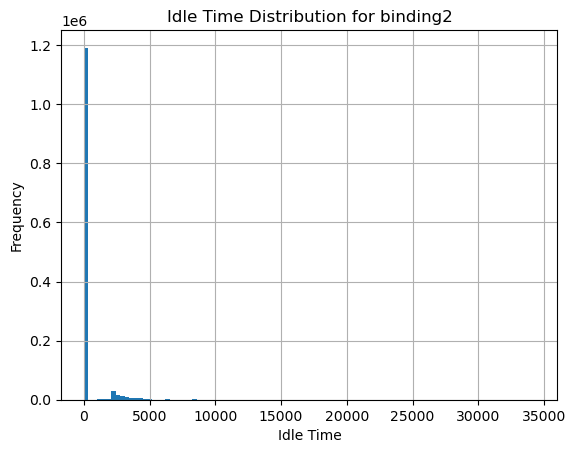

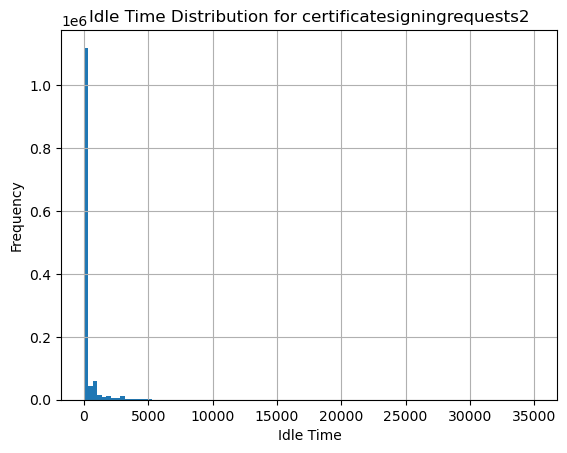

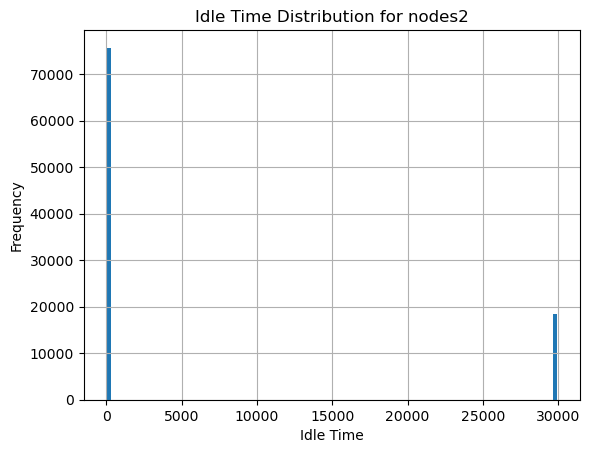

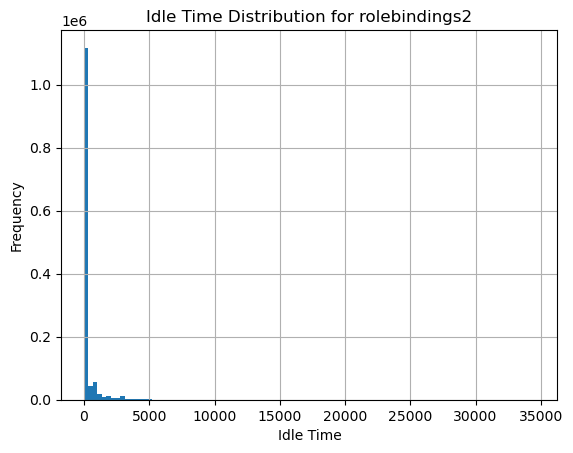

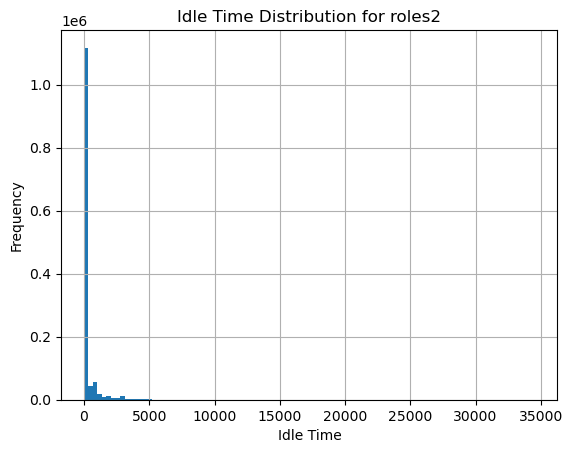

In [55]:
import matplotlib.pyplot as plt

# 获取所有唯一的metaKeys
meta_keys = requests['metaKey'].unique()

# 为每个metaKey创建一个直方图
for key in meta_keys:
    # 过滤掉请求次数小于10的metaKey
    if idle_time_stats.loc[key]['count'] < 10:
        continue
    ## 删除超出%90分位数的数据行
    col = 'idle_time'
    data = requests[requests['metaKey'] == key][col]
    quan = data.quantile(0.999)
    r = requests[requests['metaKey'] == key][data<=quan]
    r[col].hist(bins=100)

    plt.title(f'Idle Time Distribution for {key}')
    plt.xlabel('Idle Time')
    plt.ylabel('Frequency')

    plt.show()

问题： 认为它是idle time less than init。 但实际上有百分之50的请求是高并发，百分之10的请求是间隔30s。这就存在一个问题，高并发请求触发高冷启动，同时用完之后便被释放，过了30s后又来一堆高并发请求，即 11111  _______     11111 _____    111111  ______ 111111。
解决方案：用0.99分位数来作为idle time，全局还是仅 idle time less than init，尝试 or 分析

